## Importing Libraries


torch – the main PyTorch library for building and training neural networks.

numpy – used for numerical operations and array manipulations.

torchvision.datasets and torchvision.transforms – for loading and preprocessing image datasets.

TensorDataset and DataLoader from torch.utils.data – to wrap data into tensors (multi-dimensional arrays) and efficiently load it in batches during training.

train_test_split from sklearn.model_selection – to split our dataset into training and testing subsets.

In [6]:
import torch
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

## Setting Hyperparameters and Configuration Values

#### RANDOM_SEED = 42
Ensures reproducibility — setting a fixed random seed makes sure that data splits, weight initialization, and other random operations give the same results each run.

#### BATCH_SIZE = 64
The number of samples processed before the model updates its parameters.
A typical starting point that balances speed and stability.

#### LR = 0.01
Controls how fast or slow the model learns during optimization.

#### INPUT_SIZE = 784  # 28 × 28
Each MNIST image (28×28 pixels) is flattened into a 784-dimensional vector, which serves as the input size for our model.

#### TEST_VALID_SIZE = 0.4
Specifies that 40% of the total data will be temporarily held out, to later be split evenly into validation (20%) and test (20%) sets.

In [7]:
RANDOM_SEED = 42 
BATCH_SIZE = 64
LR = 0.01 
INPUT_SIZE = 784 
TEST_VALID_SIZE = 0.4 
NUM_EPOCHS = 10

## Data Preparation (A1)

#### 1. Define Transformations and Load Full Data
    ToTensor() – converts each image to a PyTorch tensor and normalizes pixel values to the range [0, 1].

    Lambda(lambda x: x.flatten()) – reshapes each 28×28 grayscale image into a single vector of 784 values.

The MNIST training (60k) and test (10k) sets are both loaded, giving a total of 70,000 images.

#### 2. Combine and Split the Dataset

The full dataset is merged, normalized, and flattened, then, a two-step stratified split is performed using train_test_split:

    Step 1: 60% Training, 40% Temporary

    Step 2: Temporary (40%) → 20% Validation + 20% Test

stratify=y_combined ensures all subsets preserve the same class distribution across digits 0–9.

After splitting, all NumPy arrays are converted back to PyTorch tensors:

    X_train = torch.tensor(X_train_np).float()
    y_train = torch.tensor(y_train_np)

#### 3. Create DataLoaders (10-Class)

The train, validation, and test tensors are wrapped into TensorDatasets and passed into DataLoaders for efficient batching and shuffling:

    DATA_LOADERS_FULL = {
        'train': DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True),
        'val': DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False),
        'test': DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
    }

shuffle=True → randomizes training order for better generalization

In [ ]:
linear_model_transforms = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Lambda(lambda x: x.flatten())
])

train_set_full = datasets.MNIST('./data', train=True, download=True, transform=linear_model_transforms)
test_set_full = datasets.MNIST('./data', train=False, download=True, transform=linear_model_transforms)

X_combined = torch.cat([train_set_full.data.float().div(255).flatten(start_dim=1),
                        test_set_full.data.float().div(255).flatten(start_dim=1)], dim=0).numpy()
y_combined = torch.cat([train_set_full.targets, test_set_full.targets], dim=0).numpy()

X_train_np, X_temp_np, y_train_np, y_temp_np = train_test_split(
    X_combined, y_combined, 
    test_size=TEST_VALID_SIZE, 
    random_state=RANDOM_SEED, 
    stratify=y_combined 
)

X_val_np, X_test_np, y_val_np, y_test_np = train_test_split(
    X_temp_np, y_temp_np, 
    test_size=0.5, 
    random_state=RANDOM_SEED, 
    stratify=y_temp_np 
)

X_train = torch.tensor(X_train_np).float()
X_val = torch.tensor(X_val_np).float()
X_test = torch.tensor(X_test_np).float()

y_train = torch.tensor(y_train_np)
y_val = torch.tensor(y_val_np)
y_test = torch.tensor(y_test_np)

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

DATA_LOADERS_FULL = {
    'train': DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True),
    'val': DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False),
    'test': DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
}

print(f"Part A1 Complete. Train Size: {len(X_train)}, Validation Size: {len(X_val)}, Test Size: {len(X_test)}")

Part A1 Complete. Train Size: 42000, Validation Size: 14000, Test Size: 14000


## Logistic Regression (A2)

### Core Components — Activation & Loss Functions

#### 1. Sigmoid Activation Function
    def sigmoid(z):
        Implementation of the Sigmoid activation function: 1 / (1 + e^(-z)).

The sigmoid maps any real-valued input z into a range between 0 and 1.

It’s commonly used in the output layer of binary classifiers to represent probabilities.

When z is large and positive → output ≈ 1

When z is large and negative → output ≈ 0

This makes it ideal for predicting probabilities such as “this image is a 5 or not.”

#### 2. Binary Cross-Entropy (BCE) Loss
    def binary_cross_entropy_loss(y_hat, y):
        Implementation of the Binary Cross-Entropy loss function.
        

Measures the difference between predicted probabilities (y_hat) and true binary labels (y).
Used to penalize incorrect predictions more strongly the more confident they are.

#### Notes:

epsilon = 1e-7 prevents taking log(0), which would cause numerical instability.

Both y and y_hat are reshaped to match dimensions for batch-wise computation.

In [9]:
# --- Core Component 1: Activation Function ---
def sigmoid(z):
    return 1 / (1 + torch.exp(-z))

# --- Core Component 2: Loss Function ---
def binary_cross_entropy_loss(y_hat, y):
    # Ensure y (target) and y_hat (prediction) have the same shape: (batch_size, 1)
    y = y.view(-1, 1)
    epsilon = 1e-7
    loss = - torch.mean(y * torch.log(y_hat + epsilon) + (1 - y) * torch.log(1 - y_hat + epsilon))
    return loss

### A2 Data Preparation — Filtering Digits 0 and 1

### Function Overview
    def create_binary_loaders(X, y, batch_size):
        Filters global tensors for classes 0 and 1, creates DataLoaders.

1. Selects samples where the label (y) is either 0 or 1.
2. Converts the filtered data into tensors.
3. Wraps them inside a PyTorch DataLoader for efficient iteration

### Step-by-Step Breakdown

#### Filter Digits 0 and 1

    indices = (y == 0) | (y == 1)
    X_binary = X[indices].float()
    y_binary = y[indices].float()


Creates a boolean mask selecting only images of digits 0 and 1.

Converts both input and labels to float type (required for Binary Cross-Entropy loss).

#### Determine Shuffle Behavior

    shuffle_status = True if X.shape[0] == X_train.shape[0] else False


Enables shuffling only for the training set (to randomize sample order each epoch).

Keeps validation and test sets unshuffled for consistency.

#### Return DataLoader

    return DataLoader(TensorDataset(X_binary, y_binary),
                    batch_size=batch_size,
                    shuffle=shuffle_status)


Wraps the filtered tensors into a TensorDataset and returns a DataLoader.

batch_size controls how many samples are processed per step.

In [10]:
def create_binary_loaders(X, y, batch_size):
    indices = (y == 0) | (y == 1)
    X_binary = X[indices].float()
    y_binary = y[indices].float() 
    
    shuffle_status = True if X.shape[0] == X_train.shape[0] else False
    
    return DataLoader(TensorDataset(X_binary, y_binary), batch_size=batch_size, shuffle=shuffle_status)

### A2 Training Function (Manual Gradient Descent)

#### Function Overview
def train_logistic_regression(loader, W, b, learning_rate):


Inputs:

    loader → DataLoader containing batches of input–label pairs

    W, b → model parameters (weights and bias)

    learning_rate → step size for parameter updates

Outputs:

    Average loss over the epoch

    Average accuracy across all samples

#### Step-by-Step Breakdown
#### 1.  Forward Pass
    Z = torch.matmul(X_batch, W) + b  # Linear output
    A = sigmoid(Z)                    # Activation (probability)

Computes the model’s predictions:

where A represents predicted probabilities (values between 0 and 1).

#### 2. Compute Loss
    loss = binary_cross_entropy_loss(A, y_batch)    

Uses the Binary Cross-Entropy (BCE) loss to measure how far predictions are from true labels.

Total loss is accumulated for averaging later:
A=σ(XW+b) *insert sigmoid func*

    total_loss += loss.item() * X_batch.size(0)

#### 3. Backward Pass
    if W.grad is not None: W.grad.zero_()
    if b.grad is not None: b.grad.zero_()
    loss.backward()


Clears previous gradients.

Uses autograd (loss.backward()) to compute new gradients
→ dL/dW and dL/db.

#### 4. Manual Parameter Update
    with torch.no_grad():
        W.data -= learning_rate * W.grad
        b.data -= learning_rate * b.grad

Performs gradient descent manually:
*insert gd func*

(This is equivalent to what an optimizer like torch.optim.SGD would do.)

#### 5. Compute Metrics
    predictions = (A >= 0.5).float().view(-1)
    correct_predictions += (predictions == y_batch).sum().item()

Thresholds predicted probabilities at 0.5 → binary class labels (0 or 1).

Tracks number of correct predictions for accuracy computation.

In [11]:
# --- A2 Training Function (Manual Gradient Descent) ---
def train_logistic_regression(loader, W, b, learning_rate):
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    
    for X_batch, y_batch in loader:
        # 1. Forward Pass
        Z = torch.matmul(X_batch, W) + b  # Linear part
        A = sigmoid(Z)                   # Activation (Probability output)
        
        # 2. Compute Loss
        loss = binary_cross_entropy_loss(A, y_batch)
        total_loss += loss.item() * X_batch.size(0)
        
        # 3. Backward Pass (Compute Gradients)
        # PyTorch calculates dL/dW and dL/db via the computation graph
        if W.grad is not None: W.grad.zero_()
        if b.grad is not None: b.grad.zero_()
        loss.backward()

        # 4. Manual Gradient Descent Update
        # Update rule: parameter = parameter - LR * gradient
        with torch.no_grad():
            W.data -= learning_rate * W.grad
            b.data -= learning_rate * b.grad
            
        # 5. Calculate Metrics
        predictions = (A >= 0.5).float().view(-1)
        correct_predictions += (predictions == y_batch).sum().item()
        total_samples += X_batch.size(0)

    avg_loss = total_loss / total_samples
    avg_accuracy = correct_predictions / total_samples
    return avg_loss, avg_accuracy

### Evaluation Function — Model Testing / Validation

### Decorator:
    @torch.no_grad() 
Disables gradient tracking — this saves memory and speeds up evaluation since we’re not updating parameters.

### Step-by-Step Explanation
#### 1. Initialize Metrics
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    all_preds = []
    all_targets = []


Keeps running totals for:
1. cumulative loss
2. correct predictions
3. number of processed samples
4. lists of predictions and targets (for later analysis)

#### 2. Forward Pass (Inference)
    Z = torch.matmul(X_batch, W) + b
    A = sigmoid(Z)

Computes the model’s predicted probability for each input:
A=σ(XW+b)

#### 3. Compute Loss
    loss = binary_cross_entropy_loss(A, y_batch)
    total_loss += loss.item() * X_batch.size(0)


Uses the same Binary Cross-Entropy loss used during training, but here it’s only for evaluation — parameters are not updated.

#### 4. Compute Accuracy
    predictions = (A >= 0.5).float().view(-1)
    correct_predictions += (predictions == y_batch).sum().item()
    total_samples += X_batch.size(0)

Converts probabilities to binary predictions (0 or 1)
Counts how many predictions match the true labels

#### 5. Collect Predictions and Labels
    all_preds.extend(predictions.tolist())
    all_targets.extend(y_batch.tolist())


Stores every prediction and corresponding target for detailed post-analysis (like plotting curves or confusion matrices).

#### 6. Compute Averages
    avg_loss = total_loss / total_samples
    avg_accuracy = correct_predictions / total_samples

Calculates the mean loss and accuracy across the entire dataset.

In [12]:
# --- Evaluation Function ---
@torch.no_grad() # Disable gradient tracking for evaluation
def evaluate_model(loader, W, b):
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    all_preds = []
    all_targets = []
    
    for X_batch, y_batch in loader:
        # Forward Pass
        Z = torch.matmul(X_batch, W) + b
        A = sigmoid(Z)
        loss = binary_cross_entropy_loss(A, y_batch)
        total_loss += loss.item() * X_batch.size(0)

        # Metrics
        predictions = (A >= 0.5).float().view(-1)
        correct_predictions += (predictions == y_batch).sum().item()
        total_samples += X_batch.size(0)
        
        all_preds.extend(predictions.tolist())
        all_targets.extend(y_batch.tolist())

    avg_loss = total_loss / total_samples
    avg_accuracy = correct_predictions / total_samples
    return avg_loss, avg_accuracy, all_targets, all_preds

### A2 Binary Logistic Regression (Digits 0 vs 1)

#### 1. Create Binary DataLoaders
    train_loader_binary = create_binary_loaders(X_train, y_train, BATCH_SIZE)
    val_loader_binary   = create_binary_loaders(X_val, y_val, BATCH_SIZE)
    test_loader_binary  = create_binary_loaders(X_test, y_test, BATCH_SIZE)

Filters the dataset to keep only samples where label == 0 or label == 1.

Creates PyTorch DataLoaders for mini-batch training and evaluation.

The training loader shuffles its data each epoch, while validation/test loaders do not.

#### 2. Initialize Parameters
    W = torch.randn(INPUT_SIZE, 1) * 0.01
    b = torch.zeros(1)
    W.requires_grad_(True)
    b.requires_grad_(True)

W → weight vector (shape [784 × 1]) initialized with small random values.

b → bias term initialized to 0.

Setting requires_grad_(True) tells PyTorch to track gradients so we can update these parameters during training.

#### 3. Prepare for Training Loop
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

Lists to record loss and accuracy at the end of each epoch, for both training and validation sets.

In [ ]:
# Create Binary DataLoaders (using global tensors from A1)
train_loader_binary = create_binary_loaders(X_train, y_train, BATCH_SIZE)
val_loader_binary = create_binary_loaders(X_val, y_val, BATCH_SIZE)
test_loader_binary = create_binary_loaders(X_test, y_test, BATCH_SIZE)

print(f"Binary Training Samples: {len(train_loader_binary.dataset)}")

W = torch.randn(INPUT_SIZE, 1) * 0.01
b = torch.zeros(1)
W.requires_grad_(True)
b.requires_grad_(True)

# 3. Training Loop Execution
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

Binary Training Samples: 8868


### Training and Evaluating the Logistic Regression Model

#### 1. Epoch Loop
    for epoch in range(NUM_EPOCHS):
        train_loss, train_acc = train_logistic_regression(train_loader_binary, W, b, LR)
        val_loss, val_acc, _, _ = evaluate_model(val_loader_binary, W, b)


Each epoch runs one full pass over the training set and validation set.

The training function:

 - Performs forward propagation, computes loss, and manually updates parameters (W, b) using gradient descent.

The validation step:

 - Runs the model in evaluation mode (no gradient computation) to check for overfitting or underfitting.

#### 2.Record Metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

Stores loss and accuracy for later visualization.
These values help you plot learning curves and analyze model performance across epochs.

#### 3. Final Test Evaluation
    test_loss, test_acc, true_labels, predictions = evaluate_model(test_loader_binary, W, b)
    print(f"Test Accuracy: {test_acc:.4f}")


After training, we evaluate the model on the unseen test set to get an unbiased estimate of performance.
The test_acc gives the final accuracy on digits 0 vs 1.

In [ ]:
for epoch in range(NUM_EPOCHS):
    train_loss, train_acc = train_logistic_regression(train_loader_binary, W, b, LR)
    
    val_loss, val_acc, _, _ = evaluate_model(val_loader_binary, W, b)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

test_loss, test_acc, true_labels, predictions = evaluate_model(test_loader_binary, W, b)

print(f"\n--- A2 Final Test Evaluation ---")
print(f"Test Accuracy: {test_acc:.4f}")

Epoch 1/10 | Train Loss: 0.2152, Train Acc: 0.9878 | Val Loss: 0.0913, Val Acc: 0.9973
Epoch 2/10 | Train Loss: 0.0698, Train Acc: 0.9966 | Val Loss: 0.0531, Val Acc: 0.9980
Epoch 3/10 | Train Loss: 0.0466, Train Acc: 0.9968 | Val Loss: 0.0392, Val Acc: 0.9980
Epoch 4/10 | Train Loss: 0.0363, Train Acc: 0.9970 | Val Loss: 0.0318, Val Acc: 0.9980
Epoch 5/10 | Train Loss: 0.0304, Train Acc: 0.9970 | Val Loss: 0.0272, Val Acc: 0.9980
Epoch 6/10 | Train Loss: 0.0265, Train Acc: 0.9973 | Val Loss: 0.0240, Val Acc: 0.9980
Epoch 7/10 | Train Loss: 0.0237, Train Acc: 0.9975 | Val Loss: 0.0217, Val Acc: 0.9980
Epoch 8/10 | Train Loss: 0.0216, Train Acc: 0.9975 | Val Loss: 0.0199, Val Acc: 0.9980
Epoch 9/10 | Train Loss: 0.0199, Train Acc: 0.9979 | Val Loss: 0.0185, Val Acc: 0.9980
Epoch 10/10 | Train Loss: 0.0186, Train Acc: 0.9979 | Val Loss: 0.0173, Val Acc: 0.9980

--- A2 Final Test Evaluation ---
Test Accuracy: 0.9976


### Loss curve plot


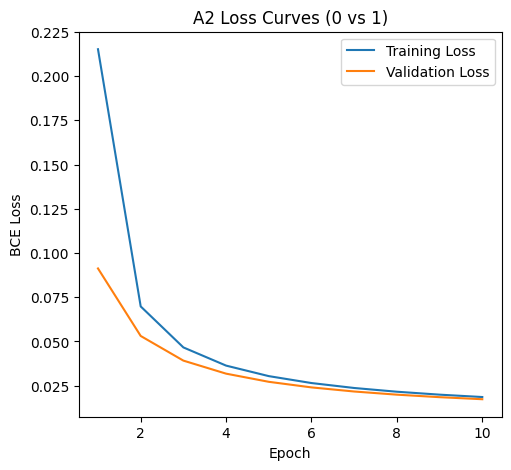

In [16]:
epochs = range(1, NUM_EPOCHS + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.title('A2 Loss Curves (0 vs 1)')
plt.xlabel('Epoch')
plt.ylabel('BCE Loss')
plt.legend()

### Accuracy curve plot


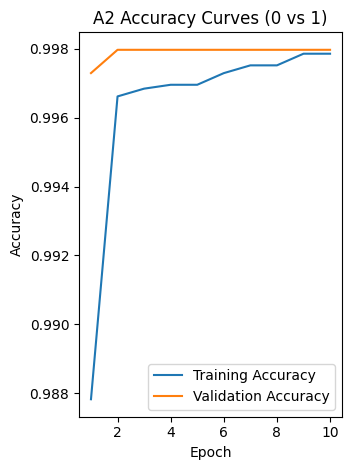

In [17]:
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.title('A2 Accuracy Curves (0 vs 1)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

### Confusion matrix


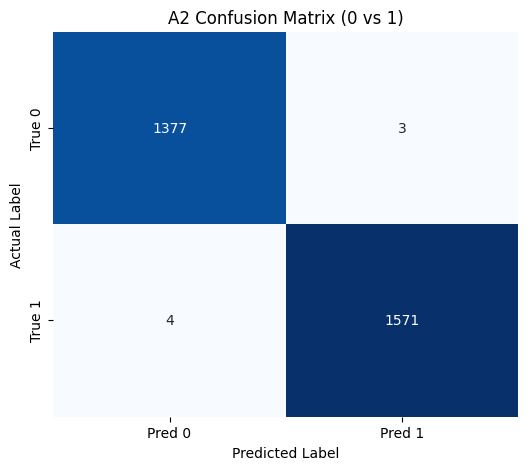

In [18]:
cm = confusion_matrix(true_labels, predictions)
cm_df = pd.DataFrame(cm, index=['True 0', 'True 1'], columns=['Pred 0', 'Pred 1'])

plt.figure(figsize=(6, 5))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('A2 Confusion Matrix (0 vs 1)')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()